In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf

In [2]:
import glob
import numpy as np
from PIL import Image
images = glob.glob('training/images_rotated/*')
gt_images = glob.glob('training/groundtruth_rotated/*')

In [3]:
def to_numpy(images):
    arr = []
    for i in images:
        arr.append(np.asarray(Image.open(i)))
    return np.array(arr)

np_imgs = to_numpy(images)

In [4]:
np_gt_imgs = to_numpy(gt_images)

In [5]:
def split_data(x, y, ratio, seed=1):
    np.random.seed(seed)
    num_row = len(y)
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(ratio * num_row))
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    x_tr = x[index_tr]
    x_te = x[index_te]
    y_tr = y[index_tr]
    y_te = y[index_te]
    return x_tr, x_te, y_tr, y_te

In [6]:
split = 0.8

X_train, X_test, y_train, y_test = split_data(np_imgs, np_gt_imgs, split)

In [7]:
y_train = np.reshape(y_train, (len(y_train), 400, 400, 1))
y_test = np.reshape(y_test, (len(y_test), 400, 400, 1))

In [8]:
X_train, X_test, y_train, y_test = X_train/255, X_test/255, y_train/255, y_test/255

In [9]:
input_shape = (len(X_train), 400, 400, 3)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Conv2D(16, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'))
model.add(tf.keras.layers.Conv2D(16, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
model.add(tf.keras.layers.Conv2D(16, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
model.add(tf.keras.layers.Conv2D(1, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 400, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 200, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      2320      
                                                                 
 up_sampling2d (UpSampling2D  (None, 200, 200, 16)     0

In [10]:
import tensorflow.keras.backend as kb
def dice_coef(y_true, y_pred, smooth=1):
    intersection = kb.sum(kb.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (kb.sum(kb.square(y_true),-1) + kb.sum(kb.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=dice_coef_loss,#tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])

model.fit(X_train, y_train, epochs=3)
model.evaluate(X_test, y_test)

Epoch 1/3
10/10 [==============================] - 32s 3s/step - loss: 0.0847 - binary_accuracy: 0.7743 - false_negatives: 11555329.0000
Epoch 2/3
10/10 [==============================] - 65s 7s/step - loss: 0.0813 - binary_accuracy: 0.7743 - false_negatives: 11555329.0000
Epoch 3/3
3/3 [==============================] - 2s 573ms/step - loss: 0.0785 - binary_accuracy: 0.7765 - false_negatives: 2861303.0000


[0.07846717536449432, 0.7764607071876526, 2861303.0]

In [12]:
test = model.predict(X_test)

In [13]:
tr = model.predict(X_train)

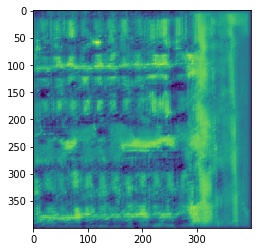

In [14]:
plt.imshow(tr[4], interpolation='nearest')
plt.show()

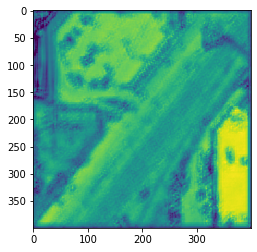

In [15]:
plt.imshow(test[0], interpolation='nearest')
plt.show()

In [ ]:
x = tf.random.normal(input_shape)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(x)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid')(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid')(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid')(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid')(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.UpSampling2D(size=(1, 2))(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.UpSampling2D(size=(1, 2))(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.UpSampling2D(size=(1, 2))(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.UpSampling2D(size=(1, 2))(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:])(y)
y = tf.keras.layers.Conv2D(1, 1, activation='relu', padding="same", input_shape=input_shape[1:])(y)
print(y.shape)

In [11]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=1)
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.1418 - accuracy: 0.9587


[0.1417786180973053, 0.9587000012397766]

In [ ]:
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.UpSampling2D(size=(1, 2)))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.UpSampling2D(size=(1, 2)))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.UpSampling2D(size=(1, 2)))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.UpSampling2D(size=(1, 2)))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=input_shape[1:]))
model.add(tf.keras.layers.Conv2D(1, 1, activation='relu', padding="same", input_shape=input_shape[1:]))

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
#from tensorflow import layers
from tensorflow.keras import layers

import matplotlib.pyplot as plt

#train_images =
#train_labels =
#test_images =
"""
X_train = X
y_train = Y
X_test = X_test
"""

cifar10 = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape)


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#class_names = ['road', 'not_road']

#import sys; sys.exit()

shapeForInput = int(400/16)

#model
model = keras.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(32, 32, 3))) # 32x32 RGB images
#model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(shapeForInput, shapeForInput, 3)))
#padding = "same"
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
print(model.summary())

#import sys; sys.exit()


loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ['accuracy']

model.compile(optimizer=optim, loss=loss) #, metrics=metrics)

#training
batch_size = 64
epochs = 5 #affect training

model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, verbose=2)
#model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

In [ ]:
def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [ ]:
def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    imgs = []
    for i in range(1, num_images+1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            print('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            imgs.append(img)
        else:
            print('File ' + image_filename + ' does not exist')

    num_images = len(imgs)
    IMG_WIDTH = imgs[0].shape[0]
    IMG_HEIGHT = imgs[0].shape[1]
    N_PATCHES_PER_IMAGE = (IMG_WIDTH/IMG_PATCH_SIZE)*(IMG_HEIGHT/IMG_PATCH_SIZE)

    img_patches = [img_crop(imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]
    data = [img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))]

    return numpy.asarray(data)

In [ ]:
# Assign a label to a patch v
def value_to_class(v):
    foreground_threshold = 0.25  # percentage of pixels > 1 required to assign a foreground label to a patch
    df = numpy.sum(v)
    if df > foreground_threshold:  # road
        return [0, 1]
    else:  # bgrd
        return [1, 0]

In [ ]:
# Extract label images
def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    gt_imgs = []
    for i in range(1, num_images + 1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            print('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            gt_imgs.append(img)
        else:
            print('File ' + image_filename + ' does not exist')

    num_images = len(gt_imgs)
    gt_patches = [img_crop(gt_imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]
    data = numpy.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    labels = numpy.asarray([value_to_class(numpy.mean(data[i])) for i in range(len(data))])

    # Convert to dense 1-hot representation.
    return labels.astype(numpy.float32)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

In [ ]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

In [ ]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)